<a href="https://colab.research.google.com/github/saraires/Proyecto-Modelos1/blob/main/04_preprocesamiento_final_y_clasificaci%C3%B3n_con_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **04 - Preprocesamiento Final y Clasificación con XGBoost**
### Santiago Palacio Cárdenas
### Sarai Restrepo Rodríguez
### Natalia Bernal Gutiérrez

Este notebook desarrolla una versión alternativa del proceso de modelado utilizando XGBoost como técnica principal de clasificación. Aquí se registran los pasos fundamentales: la carga del dataset original, la preparación estructurada de las variables, la construcción de una nueva clase para gestionar el preprocesamiento y el entrenamiento, y finalmente la evaluación del modelo resultante. El objetivo es establecer una comparación directa con implementaciones anteriores especialmente CatBoost y redes neuronales analizando cómo se comporta XGBoost bajo el mismo esquema de ingeniería de características y codificación. Este documento permite observar con claridad las fortalezas y limitaciones del método, así como su impacto sobre el rendimiento predictivo final.


# **1. Descarga y carga del conjunto de datos desde Kaggle**

En esta sección se realiza el acceso inicial al conjunto de datos oficial proporcionado para la competencia. Se parte desde los archivos originales exportados desde la plataforma y se cargan en memoria para iniciar el proceso de preparación. Este paso garantiza que el modelo trabaje siempre con la misma estructura de columnas, tipos de datos consistentes y sin modificaciones previas. A partir de aquí se deriva todo el pipeline de limpieza, codificación y modelado utilizado a lo largo del notebook.

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 432MB/s]


In [ ]:
!unzip udea*.zip > /dev/null
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


# **2. Importación de librerías y dependencias**

Antes de iniciar el proceso de preprocesamiento y construcción del modelo, es necesario cargar todas las herramientas que permitirán manejar datos, transformar variables y entrenar el clasificador XGBoost. En este apartado se reúnen todas las dependencias utilizadas a lo largo del notebook: desde librerías para manipulación de datos y codificación de categorías, hasta funciones para evaluación del desempeño y visualización de métricas. Este conjunto de importaciones establece el entorno base sobre el cual se desarrollará todo el flujo del modelo.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# **3. Construcción del clasificador basado en XGBoost**

En esta sección se desarrolla la clase que reúne todo el flujo necesario para entrenar un modelo de predicción con XGBoost. La idea es encapsular en un solo componente cada paso clave: el preprocesamiento de los datos, la codificación de variables categóricas, la generación de nuevas características relevantes y la fase completa de entrenamiento y evaluación. De esta manera, el modelo se vuelve más ordenado, reutilizable y fácil de probar tanto con los datos de entrenamiento como con los datos finales de envío. Esta clase se convierte en el núcleo del notebook, ya que centraliza la lógica del modelo y permite ejecutar todo el proceso de forma controlada y coherente.

In [ ]:
class StudentPerformanceXGBoostClassifier:

    def __init__(self):
        self.model = None
        self.label_encoders = {}
        self.performance_encoder = LabelEncoder()
        self.training_columns_ = None
        self.feature_importance = None

    def _preprocess_dataframe(self, df, training=False):
        df = df.copy()

        # ============================
        # 1. EDUCACIÓN PADRES
        # ============================
        education_mapping = {
            'Ninguno': 0, 'Primaria incompleta': 1, 'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3, 'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5, 'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7, 'Educación profesional completa': 8,
            'Postgrado': 9, 'No sabe': 4, 'No Aplica': 4, 'No reporta': 4,
            'Sin Información': 4
        }

        df["F_EDUCACIONPADRE"] = df["F_EDUCACIONPADRE"].fillna("No reporta").map(education_mapping)
        df["F_EDUCACIONMADRE"] = df["F_EDUCACIONMADRE"].fillna("No reporta").map(education_mapping)

        df["F_EDUCACION_PROM"] = (df["F_EDUCACIONPADRE"] + df["F_EDUCACIONMADRE"]) / 2
        df["F_EDUCACION_DIFF"] = abs(df["F_EDUCACIONPADRE"] - df["F_EDUCACIONMADRE"])

        # ============================
        # 2. ESTRATO
        # ============================
        estrato_mapping = {
            'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3,
            'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6,
            'Sin Estrato': 0, 'No reporta': 3
        }

        df["F_ESTRATOVIVIENDA"] = df["F_ESTRATOVIVIENDA"].fillna("No reporta").map(estrato_mapping)

        # ============================
        # 3. INTERNET
        # ============================
        df["F_TIENEINTERNET"] = df["F_TIENEINTERNET"].fillna("No").replace({"Si": 1, "No": 0})

        # ============================
        # 4. MATRÍCULA (numérica ya en tu dataset)
        # ============================
        df["E_VALORMATRICULAUNIVERSIDAD"] = df["E_VALORMATRICULAUNIVERSIDAD"].fillna(
            df["E_VALORMATRICULAUNIVERSIDAD"].mode()[0]
        )

        # ===================================================
        # 5. Codificación segura de categorías (LabelEncoder)
        # ===================================================

        categorical_cols = df.select_dtypes(include=["object"]).columns

        for col in categorical_cols:
            df[col] = df[col].fillna("No reporta")

            if training:
                le = LabelEncoder()
                unique_vals = df[col].unique().tolist()
                if "No reporta" not in unique_vals:
                    unique_vals.append("No reporta")
                le.fit(unique_vals)
                self.label_encoders[col] = le

            le = self.label_encoders[col]

            # categorías nuevas → "No reporta"
            df[col] = df[col].apply(lambda x: x if x in le.classes_ else "No reporta")

            df[col] = le.transform(df[col])

        return df

    # ------------------------------------------------------------
    # PREPROCESADO COMPLETO + SPLIT
    # ------------------------------------------------------------
    def preprocess_and_split_data(self, data):
        X = data.drop(columns=["RENDIMIENTO_GLOBAL"])
        y = data["RENDIMIENTO_GLOBAL"]

        X_processed = self._preprocess_dataframe(X, training=True)
        y_encoded = self.performance_encoder.fit_transform(y)

        # Guardar columnas entrenadas
        self.training_columns_ = X_processed.columns

        X_train, X_test, y_train, y_test = train_test_split(
            X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        return X_train, X_test, y_train, y_test

    # ------------------------------------------------------------
    # ENTRENAMIENTO
    # ------------------------------------------------------------
    def train_model(self, X_train, y_train, X_test, y_test):

        self.model = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=len(self.performance_encoder.classes_),
            eval_metric="mlogloss",
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=800,
            random_state=42,
            tree_method="hist"
        )

        self.model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=50
        )

        self.feature_importance = self.model.feature_importances_

    # ------------------------------------------------------------
    # EVALUACIÓN
    # ------------------------------------------------------------
    def evaluate_model(self, X_test, y_test):
        preds = self.model.predict(X_test)

        y_true = self.performance_encoder.inverse_transform(y_test)
        y_pred = self.performance_encoder.inverse_transform(preds)

        report = classification_report(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=self.performance_encoder.classes_)

        return report, cm

    # ------------------------------------------------------------
    # PREDICCIÓN SOBRE TEST
    # ------------------------------------------------------------
    def predict(self, X_new):
        X_prep = self._preprocess_dataframe(X_new, training=False)

        # Alinear columnas
        X_prep = X_prep.reindex(columns=self.training_columns_, fill_value=0)

        preds_encoded = self.model.predict(X_prep)
        return self.performance_encoder.inverse_transform(preds_encoded)

    # ------------------------------------------------------------
    # GUARDAR PREDICCIONES
    # ------------------------------------------------------------
    def save_predictions(self, X, output_file):
        predictions = self.predict(X)
        df_out = pd.DataFrame({
            "ID": X["ID"],
            "RENDIMIENTO_GLOBAL": predictions
        })
        df_out.to_csv(output_file, index=False)
        print(f"Archivo guardado correctamente en: {output_file}")
        return df_out



# **4. Uso de la clase**

En este bloque se inicializa el clasificador XGBoost y se ejecuta el flujo completo de trabajo: preprocesamiento, codificación de variables, división del conjunto de datos y entrenamiento del modelo. De esta forma se dejan listos tanto los datos como el modelo para continuar con la evaluación y las predicciones.

In [ ]:
# Cargar los datos
data = pd.read_csv("train.csv")

In [ ]:
# Inicializar el modelo
classifier = StudentPerformanceXGBoostClassifier()

In [ ]:
# Preprocesar y dividir los datos
X_train, X_test, y_train, y_test = classifier.preprocess_and_split_data(data)

print("✔ Preprocesamiento y división completados.")
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)



/tmp/ipython-input-2778180174.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["F_TIENEINTERNET"] = df["F_TIENEINTERNET"].fillna("No").replace({"Si": 1, "No": 0})


✔ Preprocesamiento y división completados.
Dimensiones de X_train: (554000, 22)
Dimensiones de X_test: (138500, 22)


In [ ]:
# Entrenar el modelo
print("Iniciando el entrenamiento del modelo XGBoost...")
classifier.train_model(X_train, y_train, X_test, y_test)
print("✔ Entrenamiento completado.")

Iniciando el entrenamiento del modelo XGBoost...
[0]	validation_0-mlogloss:1.37993
[50]	validation_0-mlogloss:1.25865
[100]	validation_0-mlogloss:1.23559
[150]	validation_0-mlogloss:1.22487
[200]	validation_0-mlogloss:1.21864
[250]	validation_0-mlogloss:1.21422
[300]	validation_0-mlogloss:1.21112
[350]	validation_0-mlogloss:1.20858
[400]	validation_0-mlogloss:1.20677
[450]	validation_0-mlogloss:1.20539
[500]	validation_0-mlogloss:1.20429
[550]	validation_0-mlogloss:1.20342
[600]	validation_0-mlogloss:1.20273
[650]	validation_0-mlogloss:1.20215
[700]	validation_0-mlogloss:1.20166
[750]	validation_0-mlogloss:1.20130
[799]	validation_0-mlogloss:1.20103
✔ Entrenamiento completado.


Durante el entrenamiento, XGBoost reporta de forma progresiva el valor del mlogloss sobre el conjunto de validación. Esta métrica permite observar cómo disminuye el error del modelo a medida que avanza el entrenamiento, indicando si la configuración elegida está aprendiendo de manera estable. Aunque no se generan gráficos en esta sección, el seguimiento detallado del mlogloss sirve para identificar cuándo el modelo deja de mejorar y para confirmar que el entrenamiento converge adecuadamente antes de pasar a la fase de evaluación y generación de predicciones finales.

# **5. Evaluación del rendimiento del clasificador**

Una vez entrenado el modelo, se procede a revisar su comportamiento sobre el conjunto de prueba. Las métricas obtenidas permiten observar que el algoritmo logra distinguir con mayor claridad los extremos del rendimiento académico, particularmente la categoría más alta, mientras que presenta mayores dificultades para separar correctamente las clases intermedias. Esto era esperado debido a la cercanía semántica entre “medio-alto” y “medio-bajo”, que tienden a compartir patrones similares en las variables socioeconómicas y demográficas del dataset.

In [ ]:
report, cm = classifier.evaluate_model(X_test, y_test)

print("\nReporte de Clasificación:")
print(report)


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.54      0.63      0.59     35124
        bajo       0.47      0.56      0.51     34597
  medio-alto       0.33      0.27      0.29     34324
  medio-bajo       0.33      0.27      0.30     34455

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.42    138500
weighted avg       0.42      0.43      0.42    138500




Matriz de Confusión:


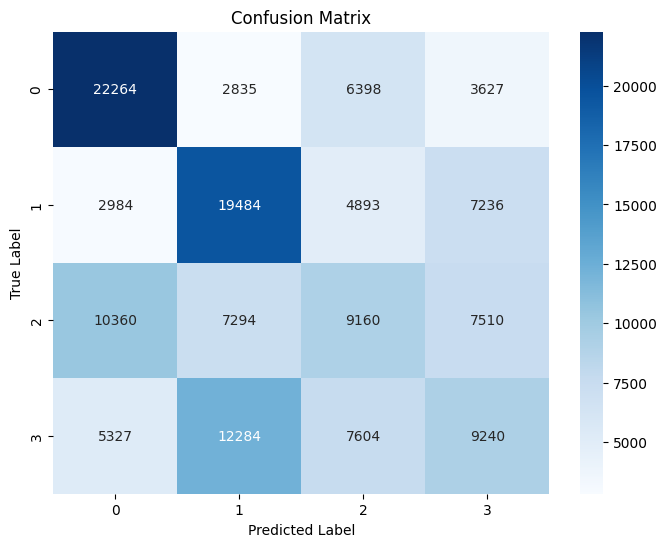

In [ ]:
print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

El análisis visual de la matriz de confusión confirma esta tendencia: gran parte de los errores se concentran en los desplazamientos entre las dos clases medias, mientras que las predicciones para los valores más extremos resultan relativamente más consistentes. Aunque el equilibrio entre precisión, recall y f1-score aún deja espacio para mejoras, los resultados sí reflejan que el modelo es capaz de capturar relaciones relevantes en los datos incluso luego de transformar completamente las variables categóricas a formato numérico.

# **6. Generación del archivo de predicciones para Kaggle**

Para finalizar el flujo de trabajo se utiliza el modelo previamente entrenado con el fin de generar las etiquetas correspondientes al conjunto de evaluación provisto por la competencia. Este proceso consiste en cargar el archivo oficial de prueba, aplicar el mismo esquema de preprocesamiento definido durante el entrenamiento y producir la columna **RENDIMIENTO_GLOBAL** con los valores predichos. Una vez obtenidos los resultados, estos se integran junto con el identificador de cada estudiante y se guardan en un archivo CSV con el formato requerido para su posterior carga en Kaggle. Este paso permite validar cómo se comporta el modelo en un escenario completamente real, donde no existe información sobre las verdaderas clases y el rendimiento del algoritmo depende exclusivamente de su capacidad de generalizar lo aprendido.


In [ ]:
# Cargar archivo test.csv
X_test = pd.read_csv("test.csv")

In [ ]:
# Generar y guardar predicciones
print("Generando archivo de envío...")
results = classifier.save_predictions(X_test, "my_submission.csv")

Generando archivo de envío...


/tmp/ipython-input-2778180174.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["F_TIENEINTERNET"] = df["F_TIENEINTERNET"].fillna("No").replace({"Si": 1, "No": 0})


Archivo guardado correctamente en: my_submission.csv


In [ ]:
# Mostrar primeras filas
results.head()

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
